In [24]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [25]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version:1.23.3
Pandas version:1.4.4
MatlpotLib version:3.5.2
Seaborn version:0.12.1
Sci-Kit Learn version:1.1.3
XGBoost version:1.7.1


In [80]:
eu = pd.read_csv('eu_new.csv', index_col=0, parse_dates=True, skipinitialspace=True)
#eu.drop('date', axis='columns', inplace=True)
eu.describe()

,open,high,low,close,volume
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.0
mean,1.245777,1.250461,1.240651,1.245802,0.0
std,0.124437,0.125134,0.124931,0.124429,0.0
min,0.959619,0.967006,0.072902,0.959619,0.0
25%,1.136506,1.139834,1.132747,1.136577,0.0
50%,1.234797,1.239403,1.229302,1.234766,0.0
75%,1.335755,1.339998,1.330118,1.335738,0.0
max,1.598184,1.602821,1.587402,1.598798,0.0


In [62]:
eu.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


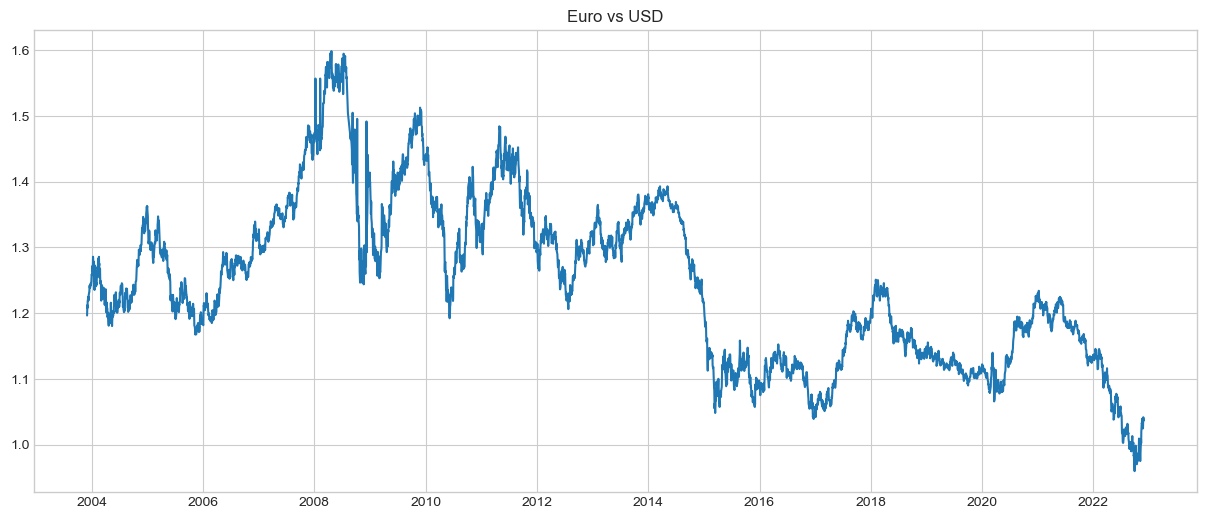

In [63]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('Euro vs USD')
plt.legend()
plt.show()

<AxesSubplot:>

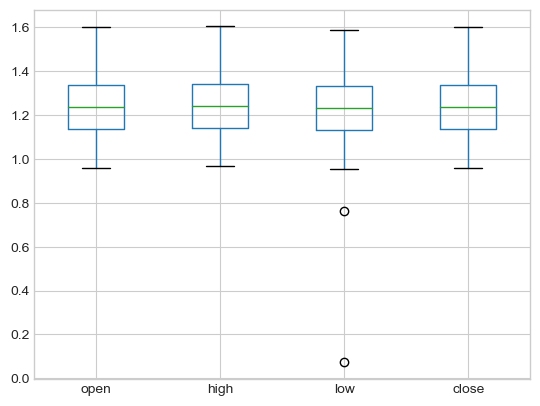

In [64]:
#box plot for open, high, low , close
eu.drop('volume', axis=1).boxplot()

In [65]:
#removing outliers above
vol_cut_off = eu.volume.std()*3 + eu.volume.mean()
eu.volume[eu.volume > vol_cut_off] = vol_cut_off

In [66]:
#removing ouliers below
vol_cut_off =  eu.volume.mean() - eu.volume.std()*3
eu.volume[eu.volume < vol_cut_off] = vol_cut_off

<AxesSubplot:>

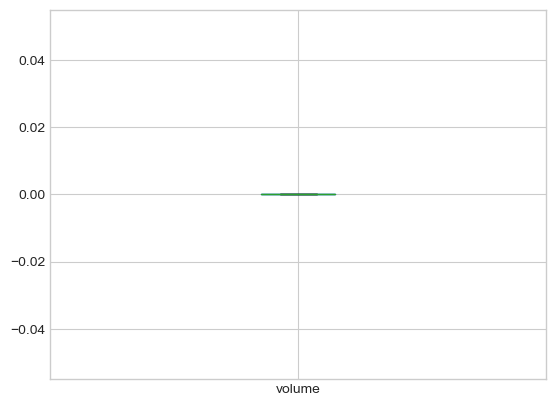

In [67]:
#boxplot for volume
eu[['volume']].boxplot()

In [70]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

In [71]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,


In [72]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

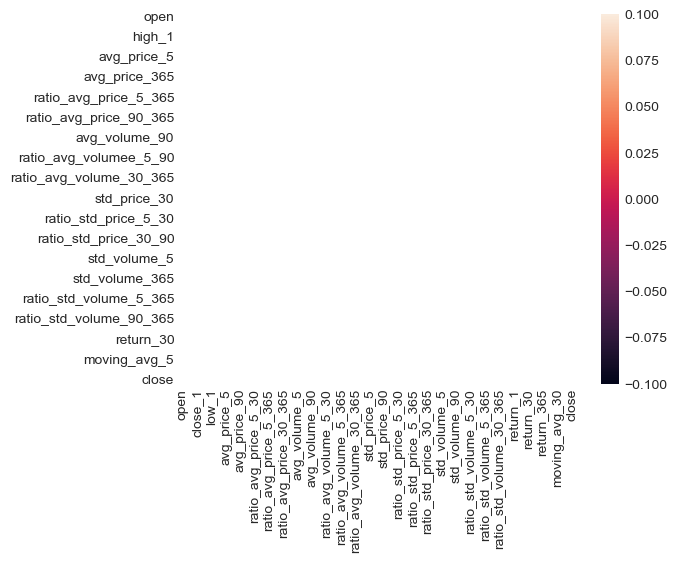

In [73]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [37]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(1999, 1, 1,0,0)
end_train = datetime.datetime(2017, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,...,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,1.207845,1.207844,1.207882,1.213555,1.202155,40948.114379,1.207882,1.207862,1.207876,1.207394,...,0.816631,0.000020,0.000097,0.000457,0.001223,0.005686,0.000021,0.000019,0.000022,1.207885
std,0.172721,0.172721,0.172677,0.173244,0.172127,40535.398337,0.172545,0.172101,0.170867,0.164983,...,0.323131,0.006320,0.013728,0.028651,0.050264,0.101303,0.002745,0.000801,0.000400,0.172676
min,0.827200,0.827200,0.826700,0.832600,0.822700,1.000000,0.833560,0.849195,0.858429,0.883636,...,0.197396,-0.026604,-0.065191,-0.147266,-0.200039,-0.241870,-0.013307,-0.003489,-0.001086,0.826700
25%,1.086760,1.086760,1.086720,1.091700,1.080950,9051.000000,1.086860,1.086086,1.093687,1.102289,...,0.575167,-0.003710,-0.008580,-0.017528,-0.033266,-0.071921,-0.001699,-0.000515,-0.000276,1.086720
50%,1.232600,1.232600,1.232320,1.238200,1.226040,13905.000000,1.232142,1.230429,1.237444,1.240565,...,0.775851,0.000106,0.000234,-0.000177,0.003242,0.008982,0.000057,0.000072,0.000055,1.232320
75%,1.336200,1.336200,1.336200,1.341000,1.329910,69037.000000,1.335616,1.333619,1.330752,1.342692,...,1.015063,0.003518,0.009024,0.018390,0.035152,0.076301,0.001813,0.000565,0.000307,1.336200
max,1.599500,1.599500,1.599700,1.603800,1.586600,132937.440396,1.591080,1.579900,1.564808,1.506541,...,1.942073,0.034903,0.106059,0.141554,0.140802,0.260726,0.020409,0.002134,0.000938,1.599700


In [38]:
#segregate data for validation
start_test = datetime.datetime(2018, 1, 1, 0, 0)
end_test = datetime.datetime(2019, 6, 7, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,...,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,1.168335,1.168551,1.168404,1.172679,1.164774,85860.709055,1.168790,1.170189,1.173200,1.175544,...,0.785246,-0.000176,-0.000785,-0.002987,-0.007239,0.014224,-0.000156,-0.000114,0.000052,1.168174
std,0.038680,0.038614,0.038646,0.039068,0.038099,28427.264667,0.038265,0.036942,0.033194,0.017669,...,0.234142,0.004373,0.009027,0.016337,0.030892,0.086742,0.001806,0.000491,0.000332,0.038700
min,1.113220,1.113220,1.113130,1.116200,1.111050,698.000000,1.116498,1.122836,1.127743,1.131791,...,0.430578,-0.019107,-0.022843,-0.046899,-0.067556,-0.094090,-0.004603,-0.001100,-0.000383,1.113130
25%,1.136580,1.136750,1.136570,1.140910,1.133530,64344.000000,1.136546,1.137379,1.139820,1.161746,...,0.569664,-0.002896,-0.007221,-0.011647,-0.025809,-0.054522,-0.001444,-0.000410,-0.000213,1.136550
50%,1.158720,1.158740,1.159300,1.162750,1.154300,79792.000000,1.161040,1.162870,1.162962,1.181830,...,0.757015,-0.000070,-0.001085,-0.003310,-0.011099,-0.017814,-0.000203,-0.000170,-0.000062,1.158770
75%,1.195030,1.195030,1.195030,1.200880,1.192600,107336.000000,1.197898,1.198645,1.202718,1.190621,...,0.953143,0.002727,0.005213,0.004623,0.005808,0.100285,0.001050,0.000101,0.000389,1.194740
max,1.250730,1.250730,1.250780,1.255540,1.244800,132937.440396,1.243208,1.237799,1.234132,1.195315,...,1.303164,0.014013,0.027068,0.045857,0.073182,0.185276,0.005369,0.001130,0.000685,1.250780


In [39]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4941, 54), (349, 54), (4941,), (349,))

### SCALING THE PREDICTOR DATA

In [40]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

### LINEAR REGRESSION (LIN)

In [41]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.005
MAE: 0.004
R^2: 0.983


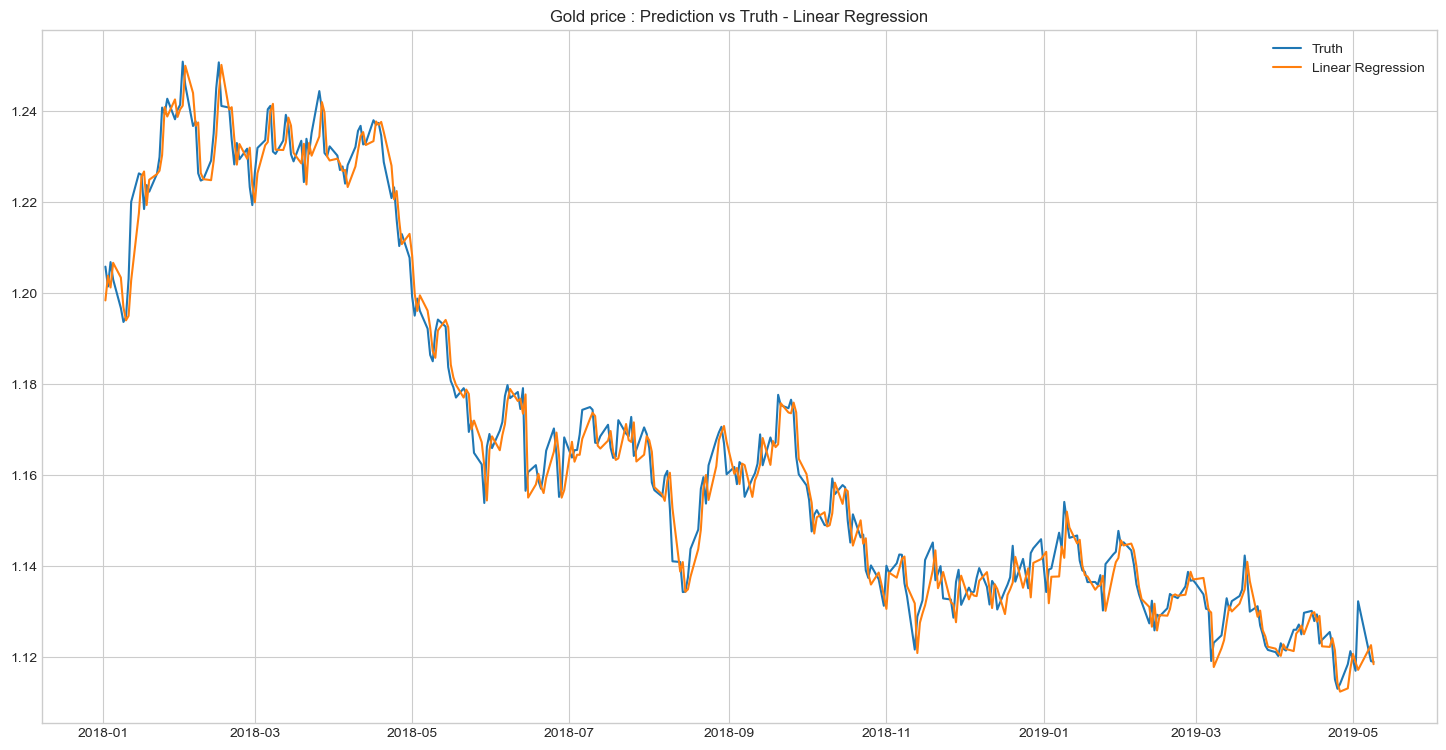

In [42]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

### SGD REGRESSOR (SGD)

In [43]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 0.005
MAE: 0.004
R^2: 0.982


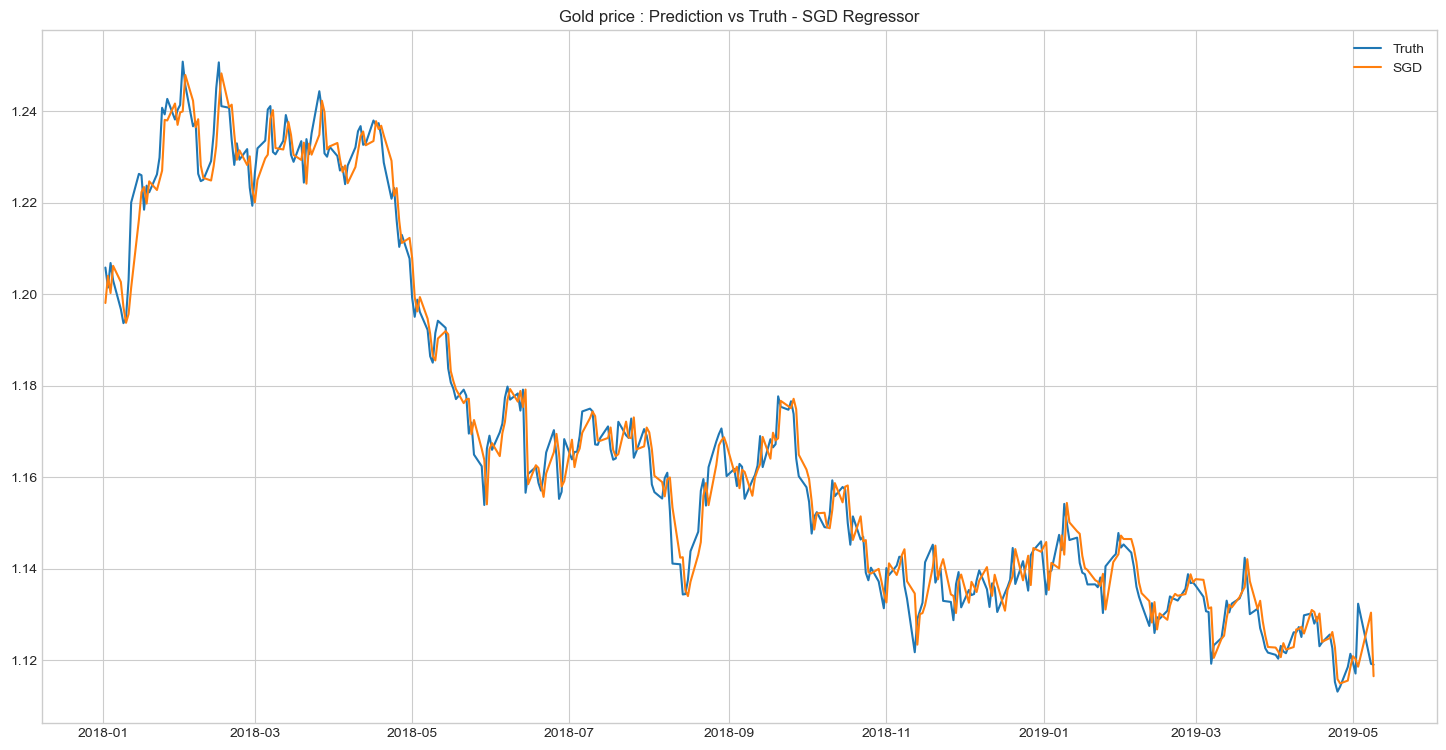

In [44]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

### Extreme Gradient Boosting Regressor (XGB)

In [45]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 1}
RMSE: 0.007
MAE: 0.006
R^2: 0.966


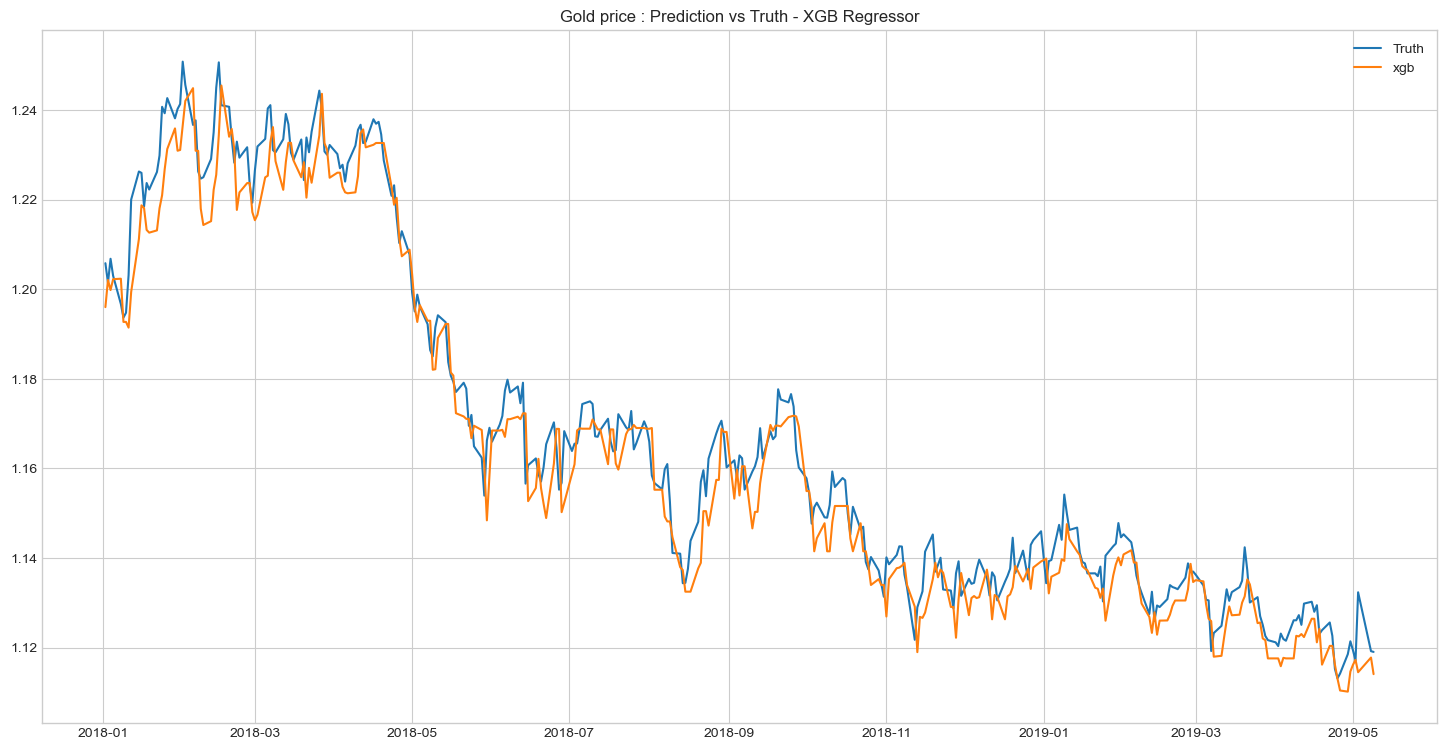

In [46]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

### Bagging Regressor (BGR)

In [47]:
BaggingRegressor?

In [48]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.005
MAE: 0.004
R^2: 0.983


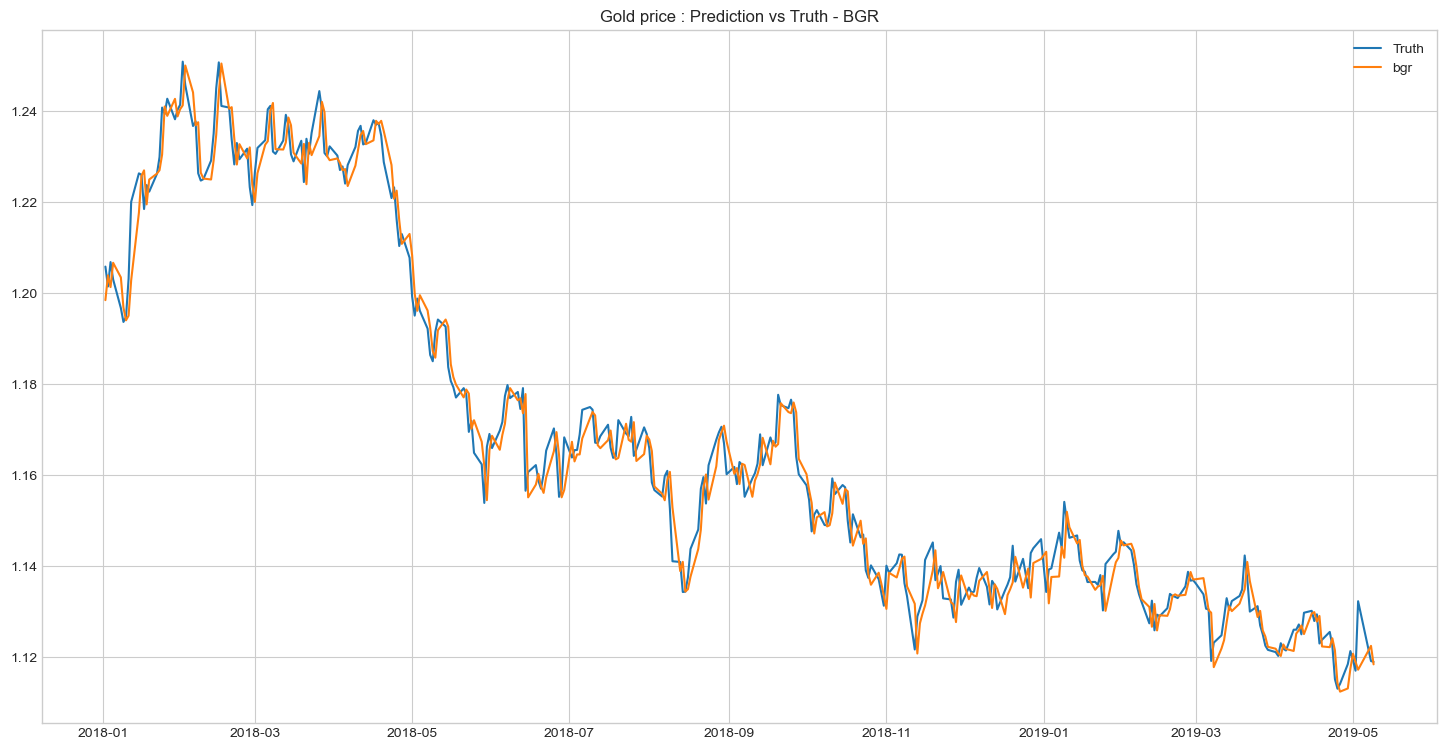

In [49]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

### Random Forest Regressor (RF)

In [50]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 30, 'min_samples_split': 5}
RMSE: 0.006
MAE: 0.005
R^2: 0.976


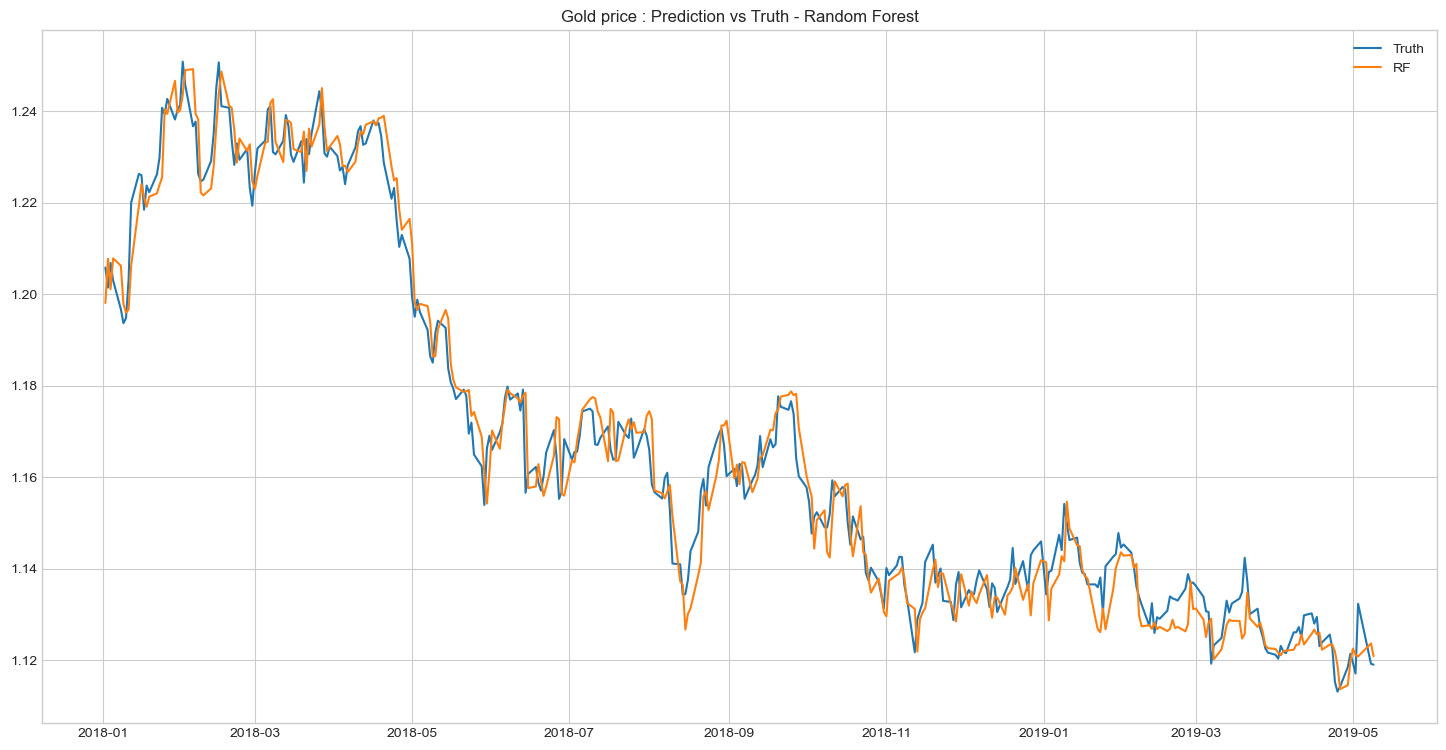

In [51]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

The model with the least mean_absolute_error:
 BGR    0.004004
dtype: float64


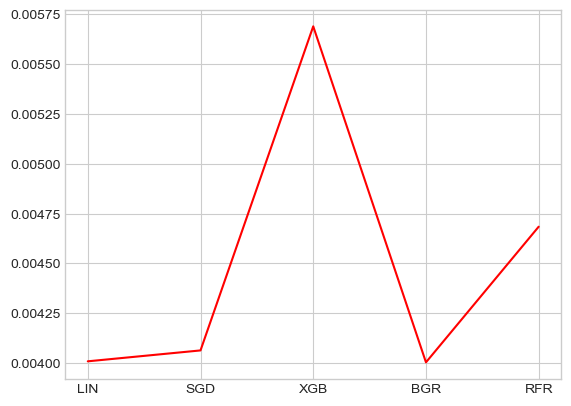

In [52]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

### Saving, Loading and Predicting with the BGR Model

In [53]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [54]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

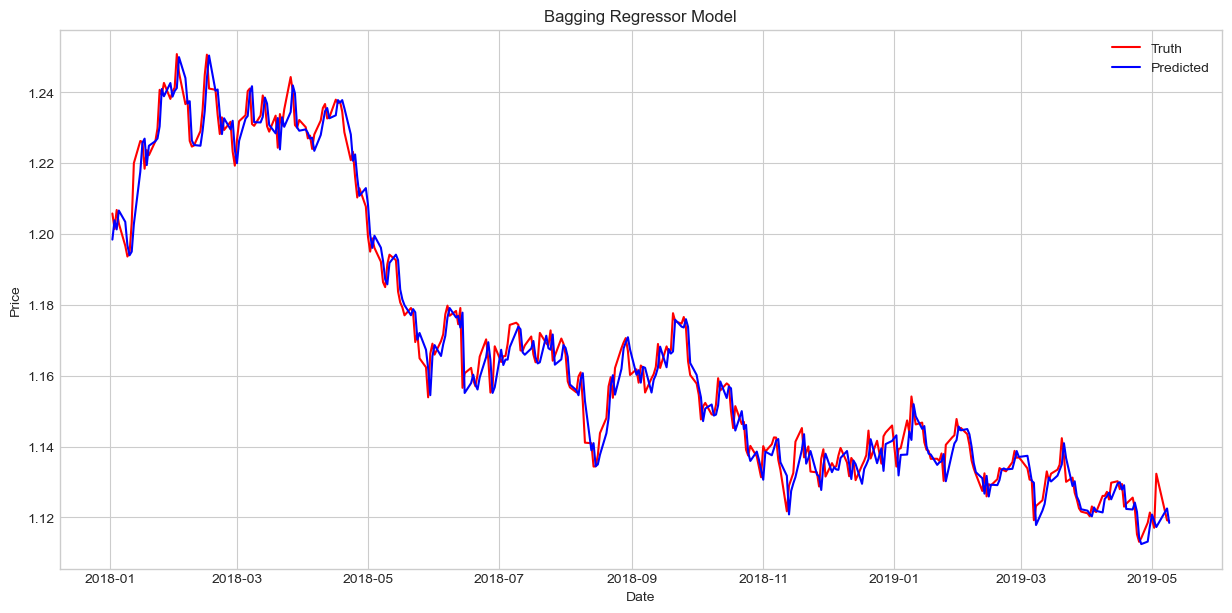

In [55]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

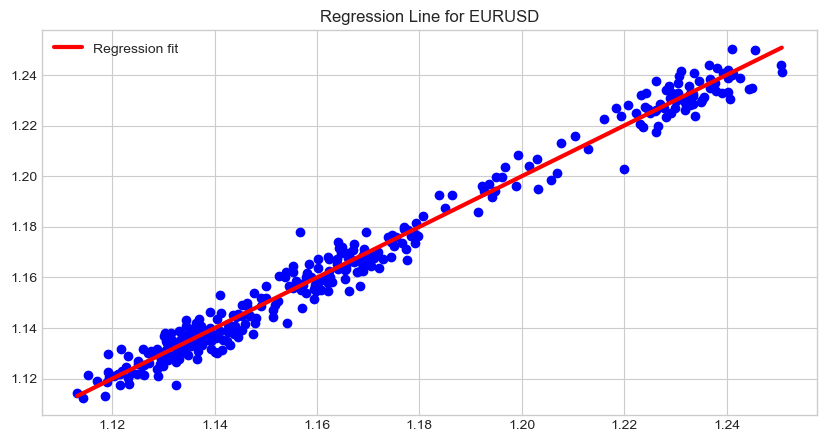

In [56]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for EURUSD")
plt.legend()
plt.show()